In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [10]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

### GAN

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

c=0.01 # диапазон весов после клиппинга из статьи 
# lr там другой, но там и RMSProp а не Adam
# генератор там учится после 5ти обучений дискриминатора, у нас пусть каждый раз учится 

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = torch.mean(output) # матожидание (среднее) на реальных
        # errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = torch.mean(output) # на фейковых
        # errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        # errD_z.backward()
        
        # loss: E(f(x)) - E(f(g(z)))
        errD = errD_z - errD_x 
        errD.backward()

        optim_D.step()
        
        # клипаем веса дискриминатора
        with torch.no_grad():
            for param in discriminator.parameters():
                param.clamp_(-c, c)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = -torch.mean(output) # -E(f(g(z)))
        
        # errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print(
                f"Epoch:{epoch + 1}",
                f"Iter: {iteration + 1}",
                f"errD_x: {errD_x.item():.2f}",
                f"errD_z: {errD_z.item():.2f}",
                f"errG: {errG.item():.2f}",
            )


Epoch:1 Iter: 100 errD_x: 0.51 errD_z: 0.49 errG: -0.49
Epoch:1 Iter: 200 errD_x: 0.50 errD_z: 0.48 errG: -0.48
Epoch:1 Iter: 300 errD_x: 0.49 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 400 errD_x: 0.50 errD_z: 0.47 errG: -0.47
Epoch:1 Iter: 500 errD_x: 0.51 errD_z: 0.48 errG: -0.48
Epoch:1 Iter: 600 errD_x: 0.52 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 700 errD_x: 0.53 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 800 errD_x: 0.52 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 900 errD_x: 0.53 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1000 errD_x: 0.54 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1100 errD_x: 0.52 errD_z: 0.49 errG: -0.49
Epoch:1 Iter: 1200 errD_x: 0.52 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1300 errD_x: 0.53 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1400 errD_x: 0.51 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 1500 errD_x: 0.50 errD_z: 0.49 errG: -0.49
Epoch:1 Iter: 1600 errD_x: 0.52 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 1700 errD_x: 0.51 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 1800 errD_x: 0.51 errD_z: 

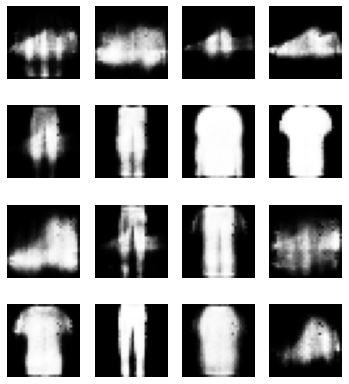

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [30]:
generator = Generator()
discriminator = Discriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

# criterion = nn.BCELoss() # не пользуемся
input = Variable(torch.FloatTensor(config.batch_size, 28 * 28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(
    torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)
)
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0


ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

alpha = 10  # это λ = 10, из статьи, не α для Adam

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = torch.mean(output)  # матожидание (среднее) на реальных
        ERRD_x[epoch] += errD_x.item()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = torch.mean(output)  # на фейковых
        ERRD_z[epoch] += errD_z.item()

        # теперь не клипаем веса, а используем grad_penalty
        # считаем x с крышкой

        # в статье "a random number eps ∼ U[0, 1].", но там алгоритм написан не для батчей
        # поэтому сгенерируем для каждого элемента батча свой случайных eps ~ U[0, 1]
        # (так результат работы много лучше, 
        # если использовать одно и то же eps для всего батча, 
        # то изображения получаются более "гранулированные" и менее красивые)
        eps = torch.rand((input_data.size(0), 1, 1, 1))
        # .data чтобы не добавлять лишние вещи в граф, ибо торч будет ругаться что пытаемся 
        # посчитать по графу градиент когда он уже якобы был посчитан по этим нодам
        x_cap = (eps * input_data.data + (1 - eps) * fake.data).requires_grad_(True)
        # считаем D(x_cap),
        errD_x_cap = discriminator(x_cap)
        # градиент этой штуки по x_cap
        grad_x_cap = torch.autograd.grad(
            outputs=errD_x_cap,
            inputs=x_cap,
            grad_outputs=torch.ones(errD_x_cap.size(), requires_grad=False),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        grad_x_cap = grad_x_cap.view(grad_x_cap.size(0), -1)
        # L2 норму всего этого, вычитаем 1 и возводим в квадрат
        # среднее сразу считаем тут, потому что без разницы когда его считать
        # в нотации в статье градиент для обновления весов считается по среднему лоссу целиком
        # который сумма наших errD_z, -errD_x, grad_penalty, но ничего страшного не случится если 
        # посчитать средние по отдельности и потом уже градиент по сумме средних
        grad_penalty = torch.mean((grad_x_cap.norm(2, dim=1) - 1.0) ** 2)
        
        # loss: E(f(x)) - E(f(g(z))) + grad_penalty
        errD = errD_z - errD_x + alpha * grad_penalty
        errD.backward()

        optim_D.step()

        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = -torch.mean(output)  # -E(f(g(z)))

        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print(
                f"Epoch:{epoch + 1}",
                f"Iter: {iteration + 1}",
                f"errD_x: {errD_x.item():.2f}",
                f"errD_z: {errD_z.item():.2f}",
                f"errG: {errG.item():.2f}",
            )


Epoch:1 Iter: 100 errD_x: 0.45 errD_z: 0.57 errG: -0.57
Epoch:1 Iter: 200 errD_x: 0.46 errD_z: 0.53 errG: -0.53
Epoch:1 Iter: 300 errD_x: 0.45 errD_z: 0.59 errG: -0.59
Epoch:1 Iter: 400 errD_x: 0.45 errD_z: 0.63 errG: -0.63
Epoch:1 Iter: 500 errD_x: 0.42 errD_z: 0.60 errG: -0.60
Epoch:1 Iter: 600 errD_x: 0.33 errD_z: 0.68 errG: -0.68
Epoch:1 Iter: 700 errD_x: 0.41 errD_z: 0.62 errG: -0.62
Epoch:1 Iter: 800 errD_x: 0.39 errD_z: 0.45 errG: -0.45
Epoch:1 Iter: 900 errD_x: 0.33 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1000 errD_x: 0.39 errD_z: 0.60 errG: -0.60
Epoch:1 Iter: 1100 errD_x: 0.43 errD_z: 0.48 errG: -0.47
Epoch:1 Iter: 1200 errD_x: 0.32 errD_z: 0.48 errG: -0.48
Epoch:1 Iter: 1300 errD_x: 0.39 errD_z: 0.65 errG: -0.65
Epoch:1 Iter: 1400 errD_x: 0.44 errD_z: 0.60 errG: -0.59
Epoch:1 Iter: 1500 errD_x: 0.46 errD_z: 0.52 errG: -0.52
Epoch:1 Iter: 1600 errD_x: 0.48 errD_z: 0.48 errG: -0.48
Epoch:1 Iter: 1700 errD_x: 0.48 errD_z: 0.48 errG: -0.48
Epoch:1 Iter: 1800 errD_x: 0.48 errD_z: 

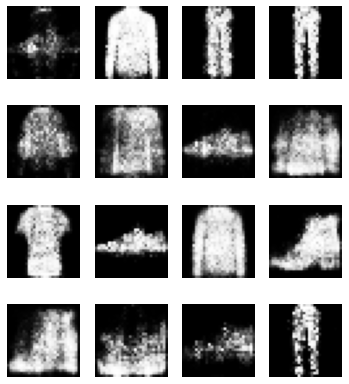

In [31]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [32]:
class LabelCondGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # укажем что теперь у нас входная размерность больше на размерность эмбеддинга лейбла
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


class LabelCondDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [33]:
generator = LabelCondGenerator()
discriminator = LabelCondDiscriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

# criterion = nn.BCELoss() # не пользуемся
input = Variable(torch.FloatTensor(config.batch_size, 28 * 28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(
    torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)
)
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0


ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

emb = nn.Embedding(10, 10)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        # прицепим эмбеддинг меток к данным
        input_data = torch.cat([input_data, emb(cat).data], 1)
        output = discriminator(input_data)
        errD_x = torch.mean(output)
        ERRD_x[epoch] += errD_x.item()

        # fake
        # для фейка теперь тоже нужны фейковые метки
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, cat.size(0))))
        
        noise.data.normal_(0, 1)
        # закидываем их в генератор
        fake = generator(torch.cat([noise, emb(fake_labels).data], 1))
        label.data.fill_(fake_label)
        # и дискриминатор
        output = discriminator(torch.cat([fake.detach(), emb(fake_labels).data], 1))
        errD_z = torch.mean(output) 
        ERRD_z[epoch] += errD_z.item()


        eps = torch.rand((input_data.size(0), 1, 1, 1))
        # интерполяция теперь как-то учитывает метки. 
        # Если взять интерполяцию только для "картинок", то непонятно как должны смешиваться метки, что такое "средняя метка"
        # с другой стороны, если есть эмбеддинг, то можно попробовать посчитать "средний" эмбеддинг между двумя метками
        x_cap = (eps * input_data.data + (1 - eps) * torch.cat([fake.detach(), emb(fake_labels).data], 1).data).requires_grad_(True)
        errD_x_cap = discriminator(x_cap)
        grad_x_cap = torch.autograd.grad(
            outputs=errD_x_cap,
            inputs=x_cap,
            grad_outputs=torch.ones(errD_x_cap.size(), requires_grad=False),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        grad_x_cap = grad_x_cap.view(grad_x_cap.size(0), -1)
        grad_penalty = torch.mean((grad_x_cap.norm(2, dim=1) - 1.0) ** 2)
        
        # loss: E(f(x)) - E(f(g(z))) + grad_penalty
        errD = errD_z - errD_x + alpha * grad_penalty
        errD.backward()

        optim_D.step()

        generator.zero_grad()
        label.data.fill_(real_label)
        # также не забываем добавить их в дискриминатор для обучения генератора
        output = discriminator(torch.cat([fake, emb(fake_labels)], 1))
        errG = -torch.mean(output)  # -E(f(g(z)))

        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print(
                f"Epoch:{epoch + 1}",
                f"Iter: {iteration + 1}",
                f"errD_x: {errD_x.item():.2f}",
                f"errD_z: {errD_z.item():.2f}",
                f"errG: {errG.item():.2f}",
            )

Epoch:1 Iter: 100 errD_x: 0.49 errD_z: 0.58 errG: -0.57
Epoch:1 Iter: 200 errD_x: 0.46 errD_z: 0.50 errG: -0.50
Epoch:1 Iter: 300 errD_x: 0.44 errD_z: 0.52 errG: -0.52
Epoch:1 Iter: 400 errD_x: 0.46 errD_z: 0.52 errG: -0.51
Epoch:1 Iter: 500 errD_x: 0.44 errD_z: 0.60 errG: -0.60
Epoch:1 Iter: 600 errD_x: 0.36 errD_z: 0.58 errG: -0.58
Epoch:1 Iter: 700 errD_x: 0.33 errD_z: 0.49 errG: -0.49
Epoch:1 Iter: 800 errD_x: 0.28 errD_z: 0.75 errG: -0.75
Epoch:1 Iter: 900 errD_x: 0.39 errD_z: 0.66 errG: -0.66
Epoch:1 Iter: 1000 errD_x: 0.44 errD_z: 0.57 errG: -0.57
Epoch:1 Iter: 1100 errD_x: 0.36 errD_z: 0.52 errG: -0.52
Epoch:1 Iter: 1200 errD_x: 0.41 errD_z: 0.51 errG: -0.51
Epoch:1 Iter: 1300 errD_x: 0.31 errD_z: 0.60 errG: -0.60
Epoch:1 Iter: 1400 errD_x: 0.33 errD_z: 0.74 errG: -0.74
Epoch:1 Iter: 1500 errD_x: 0.43 errD_z: 0.56 errG: -0.56
Epoch:1 Iter: 1600 errD_x: 0.32 errD_z: 0.61 errG: -0.61
Epoch:1 Iter: 1700 errD_x: 0.42 errD_z: 0.64 errG: -0.64
Epoch:1 Iter: 1800 errD_x: 0.41 errD_z: 

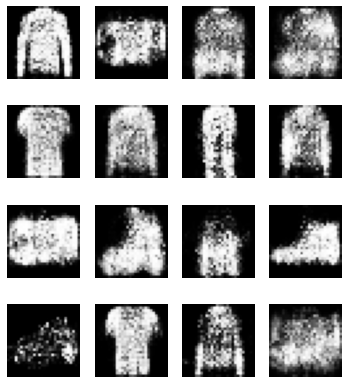

In [34]:
noise.data.normal_(0, 1)
fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))

fake = generator(torch.cat([noise, emb(fake_labels)], 1))

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Если учить вдвое дольше то картинки осмысленнее. Если клипать веса то картинки получаются ок, но достаточно смазанные, в то время как grad_penalty дает более четкие контуры и, видимо, если учить подольше то зернистость уйдет. С лейблами учить нужно ещё дольше, тогда будут норм картинки, но при тех же условиях что и другие подходы они получаются хуже